<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#new-data-because-reasons" data-toc-modified-id="new-data-because-reasons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>new data because reasons</a></span></li><li><span><a href="#Maps-dude,-the-best-frikkin-maps" data-toc-modified-id="Maps-dude,-the-best-frikkin-maps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Maps dude, the best frikkin maps</a></span><ul class="toc-item"><li><span><a href="#Mask-Mandates" data-toc-modified-id="Mask-Mandates-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mask Mandates</a></span></li><li><span><a href="#Voting" data-toc-modified-id="Voting-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Voting</a></span></li><li><span><a href="#Down-with-the-sickness" data-toc-modified-id="Down-with-the-sickness-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Down with the sickness</a></span></li></ul></li><li><span><a href="#Sick-Animations-yo" data-toc-modified-id="Sick-Animations-yo-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sick Animations yo</a></span></li></ul></div>

# Overview

In [1]:
import os, sys
sys.path.append(os.path.expanduser("~/Dropbox/Documents/Programming/Python/html2text"))
%run ./imports.ipynb

from time import sleep

import geoplot as gplt
from folium import plugins
from jinja2 import Environment, PackageLoader, FileSystemLoader

import geopandas as gpd
from matplotlib import animation, rc

from matplotlib.animation import FuncAnimation

root = Path('../').resolve()
root

Set LOG_LEVEL="INFO" before running the import file to get moar output.
Set LOG_FORMAT to change log format.
Numpy (np): 2.3.4
Scipy (sp, stats): 1.16.3
Pandas (pd): 2.3.3
MatPlotLib (mpl, plt): 3.10.7
Seaborn (sns): 0.13.2
Scikit-Learn (sk): 1.7.2
Statsmodels (sm): 0.14.5
Patsy (pt): 1.0.2
SQLAlchemy (sa): 2.0.44
ROOT_DIR: 5150_Analytics
CODE_DIR: 5150_Analytics\code
DATA_DIR: 5150_Analytics\data
FIG_DIR: 5150_Analytics\code\figures


WindowsPath('C:/Users/gaulinmp/Dropbox/Documents/School/_classes/5150_Analytics')

In [2]:
OTHER_COLOR, MASK_COLOR, NOMASK_COLOR = '#a6cee3 #1f78b4 #b2df8a'.split()

# Load Data

In [3]:
colors = list(sns.color_palette('colorblind'))

In [4]:
us = gpd.read_file(root / 'data' / 'geo' / 'us.gpkg', layer='state').query('not STUSPS.isin(["HI", "AK", "PR"])').set_geometry('geometry')
us.head(1)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00733 ..."


In [ ]:
_pop = pd.read_csv(root / 'data' / 'geo' / 'census_2020_population_zip.csv').assign(ZCTA5CE20=lambda df: df['Geographic Area Name'].str.slice(-5, None))
_zip = gpd.read_file(root / 'data' / 'geo' / 'tl_2020_us_zcta520.zip').merge(_pop[['ZCTA5CE20', 'Population']], on='ZCTA5CE20').set_geometry('geometry')
_zip['lat'] = _zip.INTPTLAT20.astype(float)
_zip['lon'] = _zip.INTPTLON20.astype(float)
_zip['zip'] = _zip['ZCTA5CE20'].astype(int)
_zip['density'] = _zip['Population'] / _zip['ALAND20'] * 5280**2
_zip['log_density'] = np.log10(_zip['density'] + 1)
_zip = _zip.query('lat.between(22, 50) and lon.between(-130, -60)')
_zip.describe()

,ALAND20,AWATER20,Population,lat,lon,zip,density,log_density
count,"33,300","33,300","33,300","33,300","33,300","33,300","33,300","33,300"
mean,"203,125,946","4,293,206","9,887",38.778,-90.475,"49,387","14,464",3.077
std,"397,766,767","17,309,439","14,886",4.752,13.689,"27,114","56,303",1.055
min,"3,551",0,0,24.545,-124.635,"1,001",0,0
25%,"21,047,652","44,149",658.750,35.428,-97.016,"26,806",223.320,2.351
50%,"90,644,682","521,680","2,653",39.475,-88.102,"49,452",890.633,2.950
75%,"225,580,882","2,593,012","13,288",42.058,-80.262,"71,674","7,711",3.887
max,"10,181,845,863","1,219,292,558","135,256",48.997,-67.009,"99,403","1,958,326",6.292


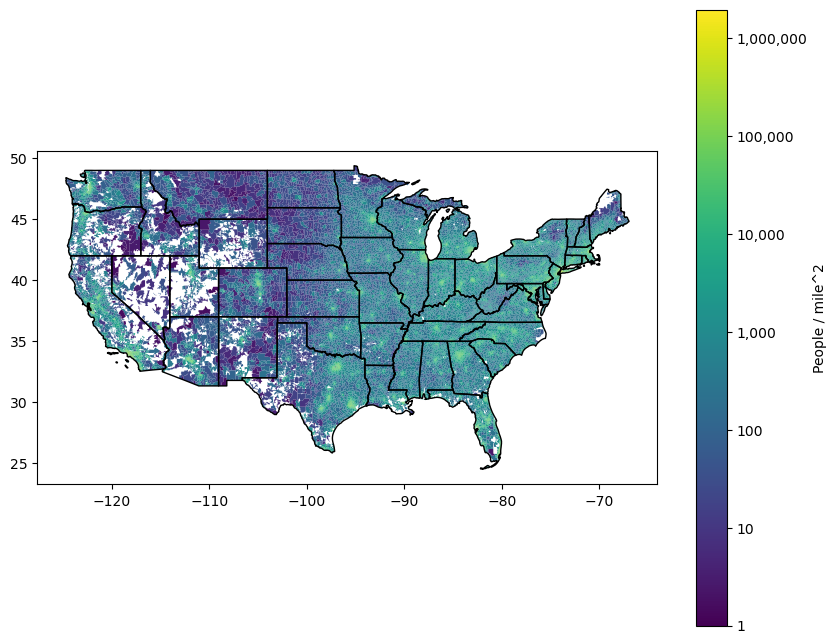

In [ ]:
ax = _zip.plot(column='log_density', cmap='viridis', figsize=(12, 6))
us.plot(edgecolor='black', facecolor='none', ax=ax)

cbar = plt.colorbar(ax.collections[0], ax=ax, label='People / mile^2')
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
cbar.set_ticklabels([f'{10**t:,.0f}' for t in cbar.get_ticks()])


In [27]:
import branca.colormap as cm
cm.linear.inferno

In [81]:
import folium
from folium.plugins import HeatMap

# Create base map centered on data
center_lat = _zip['lat'].mean()
center_lon = _zip['lon'].mean()
# Prepare heatmap data with population as weight
heat_data = [[row['lat'], row['lon'], row['log_density']]
             for _, row in _zip.assign(log_density=lambda df: (df.log_density/df.log_density.quantile(0.85)).clip(0, 1)).iterrows()]

In [84]:
map_obj = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles='CartoDB Positron')

gradient_dict = {}
for i in np.linspace(0, 1, 10):
        gradient_dict[i] = cm.linear.Reds_08.scale(0, 1).rgb_hex_str(i)

HeatMap(heat_data,
        min_opacity=0.0,
        radius=15,
        blur=10,
        gradient=#gradient_dict,
        {0.0: 'white', 0.3: 'red', .8: 'black'}
        ).add_to(map_obj)

map_obj.save('population_heatmap.html')

In [16]:
utah = gpd.read_file(root / 'data' / 'geo' / 'utah_borders.gpkg', layer='state')
counties = gpd.read_file(root / 'data' / 'geo' / 'utah_borders.gpkg', layer='county')
roads = gpd.read_file(root / 'data' / 'geo' / 'utah_borders.gpkg', layer='roads')

In [30]:
tracts = (gpd.read_file(root / 'data' / 'geo' / 'census.gpkg', layer='tract')
             .rename(columns={'geoid':'geoid_tract'})
            #  .drop(columns='Population CenterLat CenterLon StateCode CountyCode TractCode'.split())
             .replace(to_replace=["",], value=[None,])
             .assign(centers=lambda df: df.geometry.centroid)
             .set_geometry('geometry'))
tracts.count()

C:\Users\gaulinmp\AppData\Local\Temp\ipykernel_30436\554153627.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .assign(centers=lambda df: df.geometry.centroid)


StateCode      588
CountyCode     588
TractCode      588
geoid_tract    588
Population     588
CenterLat      588
CenterLon      588
geometry       588
centers        588
dtype: int64

<Axes: >

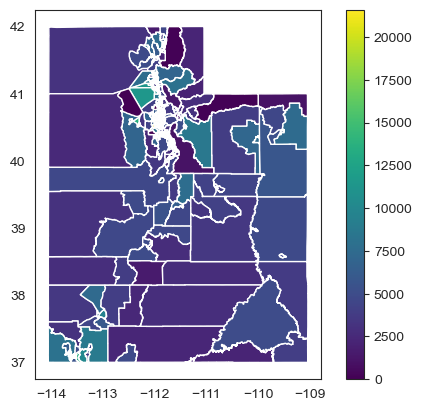

In [21]:
tracts.plot(column="Population", cmap='viridis', legend=True)

<Axes: xlabel='None', ylabel='None'>

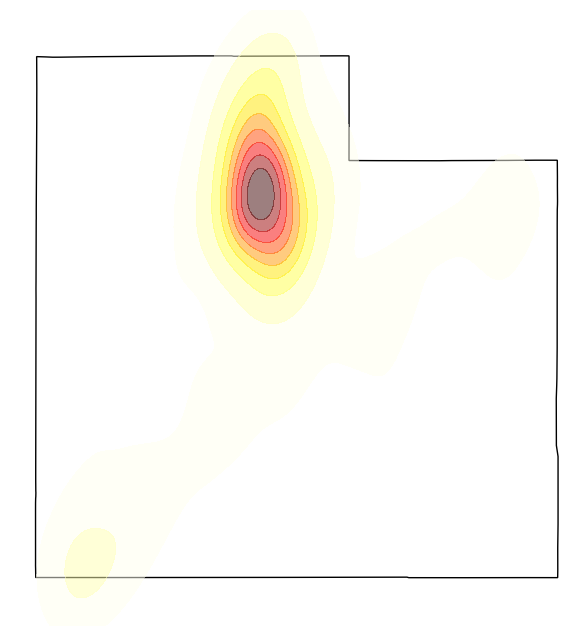

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
gplt.polyplot(utah, edgecolor='black', facecolor='none', ax=ax)
# tracts.plot(edgecolor='black', facecolor='none', ax=ax)
gplt.kdeplot(tracts.set_geometry('centers')[['Population', 'centers']], cmap='hot_r', , fill=True, ax=ax, alpha=0.5)